In [2]:
using Revise
using BenchmarkTools
using Plots

In [3]:
includet("measure_mc.jl")
includet("mcmc.jl")
includet("mk_Jij.jl")

  0.019477 seconds (29.11 k allocations: 1.479 MiB)


In [4]:
L = 12
num_spins = 3L^2
num_triangles = L^2

pos_to_spin_idx = mk_kagome(L)
;

## Spin positions on the square lattice

In [5]:
# Positions in spin_pos are defined on the square lattice (lattice constant=1)
spin_pos = Vector{Tuple{Int,Int}}(undef, num_spins)
for (k, v) in pos_to_spin_idx
    spin_pos[v] = k
end
spin_pos;

## Triangles

In [6]:
utriangles, dtriangles = mk_triangles(L)
#Convert Vector{Any} to 
utri = Vector{Vector{Int}}(utriangles)
dtri = Vector{Vector{Int}}(dtriangles)
triangles = vcat(utri, dtri);

## Definition of lattice

In [22]:
function get_reciprocal_basis_2d(a1,a2)
    b1, b2 = get_reciprocal_basis_3d(vcat(a1, 0.0), vcat(a2, 0.0), [0.0, 0.0, 1.0] )
    b1[1:2], b2[1:2]
end

function get_reciprocal_basis_3d(a1,a2,a3)
	b1 = 2π*(a2×a3)/(abs(a1 ⋅ (a2×a3)))
	b2 = 2π*(a3×a1)/(abs(a2 ⋅ (a3×a1)))
	b3 = 2π*(a1×a2)/(abs(a3 ⋅ (a1×a2)))
	return b1, b2
end

# Note: a1 and a2 must be doubled for the Honeycomb lattice
a1 = [1.0, 0.0]
a2 = [-0.5, sqrt(3)/2]
b1, b2 = get_reciprocal_basis_2d(a1,a2)

([6.283185307179586, 3.6275987284684357], [0.0, 7.255197456936871])

## Compute positions of spins in real space

In [23]:
spin_pos_rs = [0.5*p[1]*a1 + 0.5*p[2]*a2 for p in spin_pos]
;

## Fourie transform of spins for sqrt(3)xsqrt(3)

In [24]:
function compute_vcq(q, vc_corr, pos_rs)
    @assert length(vc_corr) == length(pos_rs)
    
	vcq = 0.0+0im
    R_src = pos_rs[1]
    for it in eachindex(pos_rs)
        R = pos_rs[it] .- R_src
        vcq += vc_corr[it] .* exp((q⋅R)*im)
    end
    vcq
end

compute_vcq (generic function with 1 method)

In [88]:
spins = mk_sqrt3(L);
#spins = mk_q0(L);

In [89]:
spins_array = convert_spins_to_array(spins)
fvc, afvc, vc_corr = compute_vector_chiralities(spins_array, utri, dtri)

(0.0, 1.0000000000000002, [6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75  …  -6.75, -6.75, -6.75, -6.75, -6.75, -6.75, -6.75, -6.75, -6.75, -6.75])

In [90]:
# Positions of upward triangles in real space
pos_tri_rs = [sum((spin_pos_rs[tr[isbl]] for isbl in 1:3)) for tr in triangles]
pos_tri_rs ./= 3;

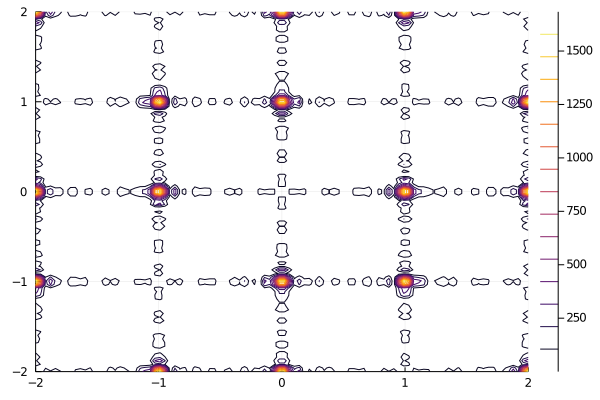

In [91]:
num_q = 100
q1s = LinRange(-2, 2, num_q)
q2s = LinRange(-2, 2, num_q)
vcq_val = Float64[]
for i in 1:num_q,j in 1:num_q
	q = q1s[i]*b1 + q2s[j]*b2
    vcq = compute_vcq((q[1],q[2]), vc_corr, pos_tri_rs)
	push!(vcq_val, abs(vcq))
end
Plots.plot(q1s,q2s,reshape(vcq_val', num_q, num_q))

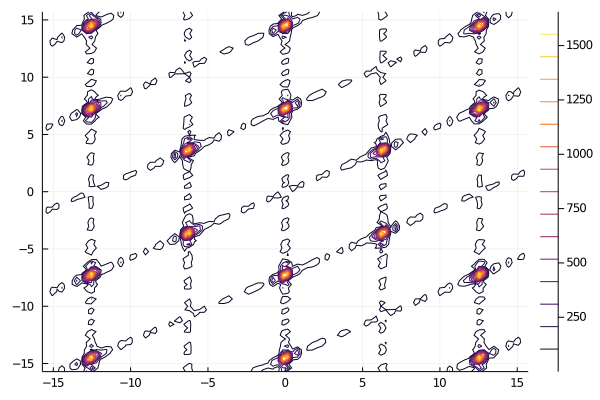

In [92]:
num_q = 100
qmax = 5π
qxs = LinRange(-qmax, qmax, num_q)
qys = LinRange(-qmax, qmax, num_q)

vcq_val = Float64[]
for i in 1:num_q,j in 1:num_q
    vcq = compute_vcq((qxs[i], qys[j]), vc_corr, pos_tri_rs)
	push!(vcq_val, abs(vcq))
end
Plots.plot(qxs,qys,reshape(vcq_val', num_q, num_q))

In [93]:
compute_vcq((0.0, 2sqrt(3)π), vc_corr, pos_tri_rs)

0.0 + 1.1733232136984772e-12im

In [94]:
compute_vcq((0.0, 0.0), vc_corr, pos_tri_rs)

0.0 + 0.0im

In [80]:
2sqrt(3)π

10.882796185405306